In [6]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pyvis.network import Network



#import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy.random import default_rng


import seaborn as sns
import numpy as np
import random
import logging
import pickle
import time
import ast



import os
import re

from multiprocess import Pool

from tqdm import tqdm

In [2]:
class SocialAgent(Agent):
    """Agent with personal network and state."""    
    def __init__(self, unique_id, model, n_nodes_int_belief, connected_agents, beta_values, beta_soc, rep, extNet, weight_ext):

        super().__init__(unique_id, model)
        
        self.unique_id = unique_id
        #self.runs = runs
        self.n_nodes = n_nodes_int_belief
        self.connected_agents = connected_agents
        self.beta_intPers = beta_values['intPers']
        self.beta_intSoc = beta_values['intSoc']
        #self.beta_intSoc_dynamic = beta_soc
        self.beta_ext = beta_values['ext']
        self.extNet = extNet
        self.weight_ext = weight_ext
        self.fullConnNet = 0 #here, a full network will be stored
        self.pers_belief_network = self.create_belief_network(self.unique_id ,self.n_nodes, self.connected_agents, weight_int_pers = 0.4, weight_int_soc = 1.0)
        self.rep = rep
        
        

    def create_belief_network(self, unique_id, n_nodes, connected_agents, weight_int_pers, weight_int_soc):

        
        seed = os.getpid() + random.randint(1, 100)
        rng = default_rng(seed)

        G = nx.DiGraph()

        for i in range(n_nodes):
            if i == 0: 
                G.add_node(f'agent{unique_id}_focal_belief', value=rng.choice(np.linspace(-1, 1, 7))) 
            else:
                G.add_node(f'agent{unique_id}_belief_{i}', value=rng.choice(np.linspace(-1, 1, 7)))

        for c in connected_agents:
            G.add_node(f'agent{unique_id}_soc_belief_{c}', value=rng.choice(np.linspace(-1, 1, 7)))

            #print(f'agent{unique_id}_soc_belief_{c}')


        focal_node = f'agent{unique_id}_focal_belief'

        for i in range(1, n_nodes):
            G.add_edge(focal_node, f'agent{unique_id}_belief_{i}', weight=weight_int_pers)  
            G.add_edge(f'agent{unique_id}_belief_{i}', focal_node, weight=weight_int_pers)
            for j in range(1, n_nodes):
                if i != j:
                    G.add_edge(f'agent{unique_id}_belief_{j}', f'agent{unique_id}_belief_{i}', weight=weight_int_pers)  
                    G.add_edge(f'agent{unique_id}_belief_{i}', f'agent{unique_id}_belief_{j}', weight=weight_int_pers) 

        for c in connected_agents:
            G.add_edge(focal_node, f'agent{unique_id}_soc_belief_{c}', weight = weight_int_soc)
            G.add_edge(f'agent{unique_id}_soc_belief_{c}', focal_node, weight = weight_int_soc)


        return G
    

    

    def step(self):
        #print(connected_agents)
        self.create_full_connected_network(self.pers_belief_network, self.connected_agents)
        self.update_state()
        
    def get_value_dict(self):
        
        
        G = self.pers_belief_network
        beta_dict = self.beta_intSoc_dynamic
        
        upper_limit = self.beta_intSoc*2
        
    
        focal_node = list(G.nodes(data=True))[0][1]['value']

        soc_beliefs = {int(index.split('_')[3]): belief['value']  for index, belief in G.nodes(data=True) if 'soc_belief' in index}

        for key, value in soc_beliefs.items():

            diff = abs(focal_node - value)
            norm = self.get_y_value(diff)

            
            current_value = beta_dict[key][-1]
            increment = (norm - 1)  * current_value * (1 - current_value / upper_limit)
            current_value += increment
            current_value = min(current_value, upper_limit)
            
            beta_dict[key].append(current_value)

        self.beta_intSoc_dynamic = beta_dict
        

    def dynamic_betas(self, adj_matrix):
        
        G = self.pers_belief_network
        beta_dict = self.beta_intSoc_dynamic
        adj = adj_matrix
    
        soc_belief_coords = {int(belief.split('_')[3]): index for index, belief in enumerate(G.nodes()) if 'soc_belief' in belief}

        for key, value in soc_belief_coords.items():
            #print(key, value, beta_dict)
            adj[value][0] = beta_dict[key][-1]
            adj[0][value] = beta_dict[key][-1]


        return adj
    
    
    
    def exponential_decay(self, x, a, b):

        return a * np.exp(-b * x)


    

    def get_y_value(self, x):

        a = 1.5           # starting point
        b = 1           # decay parameter, the higher, the stronger the decay
    
        y = self.exponential_decay(x, a, b)
        
        return y
    
    
    def create_full_connected_network(self, focal_network, connected_agents):
        

        soc_beliefs_networks = [(connected_agent.unique_id, connected_agent.pers_belief_network) for connected_agent in self.model.schedule.agents if connected_agent.unique_id in connected_agents]

        fullNet = focal_network.copy()

        for id, net in soc_beliefs_networks:


            fullNet = nx.compose(fullNet, net)
            fullNet.add_edge(f'agent{id}_focal_belief', f'agent{self.unique_id}_soc_belief_{id}', weight = self.weight_ext)
            fullNet.add_edge(f'agent{self.unique_id}_focal_belief', f'agent{id}_soc_belief_{self.unique_id}', weight = self.weight_ext)



        self.fullConnNet = fullNet





    def update_state(self):

        fullNet = self.fullConnNet
        pers_net_nodes = self.pers_belief_network.nodes()

        fullNet_adj = nx.adjacency_matrix(fullNet).toarray()
        fullNetSim = fullNet_adj.copy()
     
        #fullNetSim = self.dynamic_betas(fullNetSim)
        
        fullNetSim[fullNet_adj == 0.4] = fullNet_adj[fullNet_adj == 0.4] * self.beta_intPers
        fullNetSim[fullNet_adj == 1.0] = fullNet_adj[fullNet_adj == 1.0] * self.beta_intSoc
        fullNetSim[fullNet_adj == 1.4] = fullNet_adj[fullNet_adj == 1.4] * self.beta_ext
        
        #self.get_value_dict()
        
        
        for index, node in enumerate(pers_net_nodes):

            probUnstPerValue = []
            for k in range(7):
                connections = np.delete(fullNetSim[index], index)

                currentState = fullNet.nodes[node]['value']
                flippedState = np.linspace(-1, 1, 7)[k]
                connectedStates = [data['value'] for _, data in fullNet.nodes(data=True)]
                connectedStates = np.delete(np.array(connectedStates), index)

                probUnstPerValue.append(1/(1+ np.exp((-np.sum(connections * flippedState * connectedStates) + np.sum(connections * currentState * connectedStates)))))

            probPerValue = [k / sum(probUnstPerValue) for k in probUnstPerValue]
            
            a = np.random.choice(np.linspace(-1, 1, 7), 1,  p=probPerValue)[0]
            ###########################BUG fullNet.nodes[f'agent{self.unique_id}_belief_0']['value'] = a
            fullNet.nodes[node]['value'] = a
            
        updated_pers__network = fullNet.subgraph(pers_net_nodes).copy()
        self.pers_belief_network = updated_pers__network
        
        

        
        
    def get_focal_node_states(self):
        
        focal_node = self.pers_belief_network.nodes()[f'agent{self.unique_id}_focal_belief']['value']

        return focal_node
    
    
    def get_mean_node_states(self):

        pattern = r'agent(\d+)_belief_(\d+)'
        
        nodes = [data['value'] for i, data in self.pers_belief_network.nodes(data=True) if re.match(pattern, i)]

        mean_node_states = (sum(nodes)/len(nodes))

        return mean_node_states
    
    def get_node_states(self):
        
        #nodes = [(i, data['value']) for i, data in self.pers_belief_network.nodes(data=True)]
        nodes = self.pers_belief_network
        
        return nodes
    
    def get_extNet(self):
        
        return self.extNet
    
    
    def get_dynamic_beta(self):

        soc_beliefs = {int(index.split('_')[3]): belief['value']  for index, belief in self.pers_belief_network.nodes(data=True) if 'soc_belief' in index}
        
        latest_beta = {key : (soc_beliefs[key], value[-1]) for key, value in self.beta_intSoc_dynamic.items()}
            
        return latest_beta
            
        
    
    def get_test(self):
        
        return self.test
   

In [3]:
class NetworkModel(Model):   
    
    def __init__(self, n_nodes_int_pers, n_nodes_soc, beta_variations, ext_net, rep):

        super().__init__()

        self.schedule = RandomActivation(self)
        self.n_nodes_soc = n_nodes_soc
        self.n_nodes_int_pers = n_nodes_int_pers
        self.beta_variations = beta_variations
        self.ext_net = ext_net
        self.rep = rep       
        


        beta_soc = {}

        # Initialize agents and assign to external network nodes
        for i, node in enumerate(self.ext_net.nodes()):
            connected_agents = list(self.ext_net.neighbors(i))
            beta = self.beta_variations
            #for c in connected_agents:
            beta_soc = {c:[self.beta_variations['intSoc']] for c in connected_agents}
            #beta_soc = {c:[1] for c in connected_agents}
            #network = create_belief_network(i, self.n_nodes_int_pers, connected_agents, weight_int_pers=0.4, weight_int_soc=1.0)
            agent = SocialAgent(i, self, self.n_nodes_int_pers, connected_agents, self.beta_variations, beta_soc, self.rep, self.ext_net, weight_ext=1.4)
            self.schedule.add(agent)

        self.datacollector = DataCollector(
            agent_reporters={"betaIntPers" : "beta_intPers"
                             , "betaIntSoc" : "beta_intSoc"
                             , "betaExt" : "beta_ext"
                             , "rep" : "rep"
                             , "focalNodeStates" : SocialAgent.get_focal_node_states
                             , "meanNodeStates" : SocialAgent.get_mean_node_states
                             , "NodeStates" : SocialAgent.get_node_states
                             , "extNet" : SocialAgent.get_extNet
                             #, "dynamic_betas" : SocialAgent.get_dynamic_beta
                            })
            #model_reporters={"focalNodeStates" : self.get_focal_node_states,
            #                 "meanNodeStates" : self.get_mean_node_states}
                             
                

    def step(self):
        #if self.schedule.steps > 38:
        self.datacollector.collect(self)
        #print(self.schedule.steps)
            
        self.schedule.step()

  

In [4]:
sizes = [100 // 4, 100 // 4, 100 // 4, 100 // 4]
p_matrix = [[0.4, 0.01, 0.01, 0.01], [0.01, 0.4, 0.01, 0.01], [0.01, 0.01, 0.4, 0.01], [0.01, 0.01, 0.01, 0.4]]
ext_net4 = nx.stochastic_block_model(sizes, p_matrix)

sizes = [100]
p_matrix = [[0.2]]
ext_net1 = nx.stochastic_block_model(sizes, p_matrix)

sizes = [100 // 2, 100 // 2]
p_matrix = [[0.4, 0.01], [0.01, 0.4]]
ext_net2 = nx.stochastic_block_model(sizes, p_matrix)

extNets = [ext_net1, ext_net2, ext_net4]

In [5]:
def run_simulation(params):

    model = NetworkModel(params['n_nodes_int_pers'], params['n_nodes_soc'], params['beta_variations'], params['ext_net'], params['n_reps'])
    #while model.schedule.steps < params['n_steps']:
    for _ in range(params['n_steps']):
        model.step()

    # Extract and return simulation data
    agent_data = model.datacollector.get_agent_vars_dataframe()
    #model_data = model.datacollector.get_model_vars_dataframe()

    #data = pd.concat([agent_data, model_data], axis = 1)
    return agent_data





def define_param_list(n_reps, n_nodes_int_pers, n_nodes_soc, n_steps, beta_values):
    
    sizes = [n_nodes_soc // 4, n_nodes_soc  // 4, n_nodes_soc  // 4, n_nodes_soc  // 4]
    p_matrix = [[0.4, 0.01, 0.01, 0.01], [0.01, 0.4, 0.01, 0.01], [0.01, 0.01, 0.4, 0.01], [0.01, 0.01, 0.01, 0.4]]
    ext_net = nx.stochastic_block_model(sizes, p_matrix)
    #ext_net_adj = nx.adjacency_matrix(ext_net).toarray()
    #np.save(f"data/extNet{n_nodes_soc}_{n_steps}.npy", ext_net_adj)


        
    #with reps:
    params = [{'ext_net': ext_net,'n_nodes_int_pers' : n_nodes_int_pers, 'n_nodes_soc' : n_nodes_soc, 'n_steps' : n_steps, 'n_reps' : i, 'beta_variations' : {'intPers': p, 'intSoc': s, 'ext': e}} for i in range(n_reps) for p in beta_values for s in beta_values for e in beta_values]
    #params = [{'ext_net': ext_net,'n_nodes_int_pers' : n_nodes_int_pers, 'n_nodes_soc' : n_nodes_soc, 'n_steps' : n_steps, 'n_reps' : i, 'beta_variations' : {'intPers': p, 'ext': e}} for i in range(n_reps) for p in beta_values for e in beta_values for ext_net in extNets]

    #without reps
    #params = [{'ext_net': ext_net,'n_nodes_int_pers' : n_nodes_int_pers, 'n_nodes_soc' : n_nodes_soc, 'n_steps' : n_steps, 'beta_variations' : {'intPers': p, 'intSoc': s, 'ext': e}} for p in beta_values for s in beta_values for e in beta_values]

    return params



def pool_simulation(n_cores, params):
    sim_results= []

    pool = Pool(n_cores)

    for result in tqdm(
        pool.imap_unordered(func=run_simulation, iterable=params),
        total=len(params)
        ):
            #result['durchgang'] = params['n_reps']
            sim_results.append(result)

        
    pool.close()

    return pd.concat(sim_results)


In [17]:
sim_results = pool_simulation(12, define_param_list(n_reps = 4, n_nodes_int_pers=10, n_nodes_soc=100, n_steps=25, beta_values=[0.5, 2]))


100%|██████████| 64/64 [19:15<00:00, 18.06s/it]  


In [18]:
def set_identifier(df_s):
    
    df_s = df_s.reset_index()
    df_s['identifier'] = df_s.apply(lambda x: f"{x['betaIntPers']}-{x['betaIntSoc']}-{x['betaExt']}-{x['rep']}", axis=1)
    #df_s['identifier'] = df_s.apply(lambda x: f"{x['betaIntPers']}-{x['betaExt']}-{x['rep']}", axis=1)

    # Step 2: Convert the identifier to a categorical type and assign codes
    df_s['id'] = df_s['identifier'].astype('category').cat.codes
    df_s = df_s.drop(columns = ['identifier'])
    df_s = df_s[['betaIntPers', 'betaIntSoc', 'betaExt', 'AgentID', 'Step', 'id', 'focalNodeStates', 'meanNodeStates', "NodeStates", "rep", "extNet", "dynamic_betas"]]#, "Test"]]
    #df_s = df_s[['betaIntPers', 'betaExt', 'AgentID', 'Step', 'id', 'focalNodeStates', 'meanNodeStates', "NodeStates", "rep", "extNet", "dynamic_betas"]]#, "Test"]]

    #df_s = df_s.rename(columns = {'durchgang' : 'rep'})
    
    return df_s

In [19]:
sim = set_identifier(sim_results)

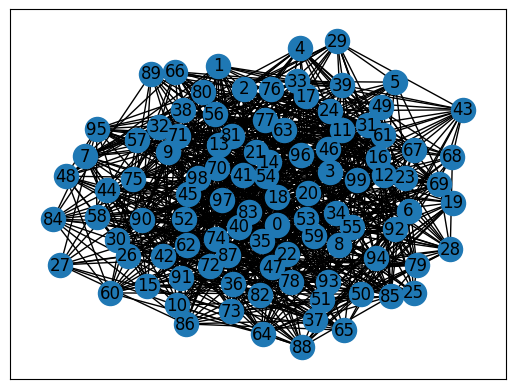

In [454]:
nx.draw_networkx(sim.loc[sim.edges == sim.edges.unique()[i]].iloc[0].extNet)

plt.savefig(f'mesa_sim_figures/cluster{i}.svg', format='svg')

plt.show()

In [455]:
#sim_a = sim[(sim.betaIntPers == 2) & (sim.betaExt == 2) &  (sim.edges == uni[i])]
sim_a = sim[(sim.edges == uni[i])]
uni[i]


1007

In [29]:
#df = sim_stat[(sim_stat.betaIntPers == 2) & (sim_stat.betaIntSoc == 2) & (sim_stat.betaExt == 2)]
df = sim[(sim.betaIntSoc == 2) & (sim.Step <= 25)]

In [25]:
state_counts = df.groupby(['Step', 'focalNodeStates']).size().reset_index(name='count')

total_counts = state_counts['count'].sum()
state_counts['normalized_count'] = state_counts['count'] / total_counts*100

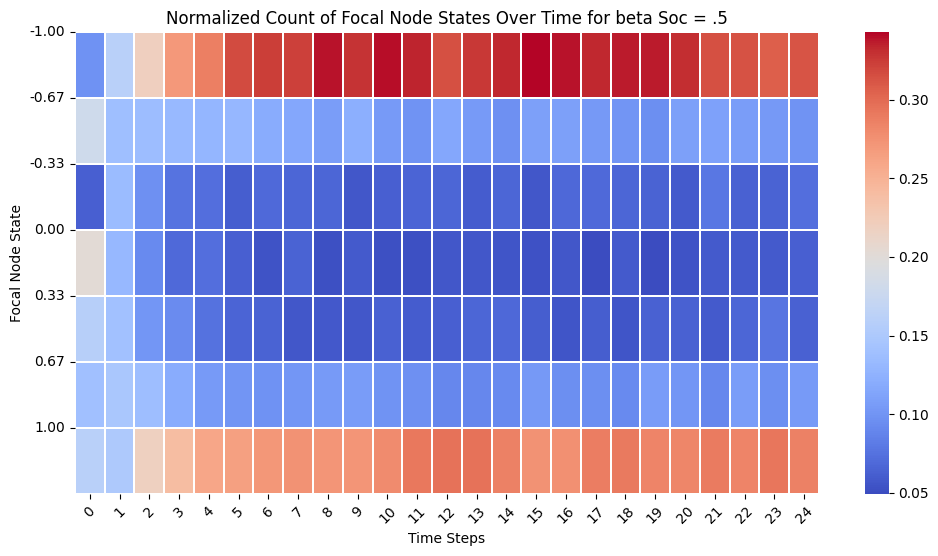

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'Step' and 'focalNodeStates' and count occurrences
state_counts = df.groupby(['Step', 'focalNodeStates']).size().reset_index(name='count')

# Normalize the count values to be between 0 and 1 for each 'Step' group
state_counts['normalized_count'] = state_counts.groupby('Step')['count'].transform(lambda x: x / x.sum())

# Pivot to create a table for the heatmap
pivot_data = state_counts.pivot_table(index='focalNodeStates', columns='Step', values='normalized_count', fill_value=0)

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='coolwarm', linewidths=0.1, linecolor='white', annot=False)

# Customize the plot
plt.title('Normalized Count of Focal Node States Over Time for beta Soc = .5')
plt.xlabel('Time Steps')
plt.ylabel('Focal Node State')
plt.xticks(rotation=45)

# Round y-axis labels to two decimal places
yticks = pivot_data.index
plt.yticks(ticks=range(len(yticks)), labels=[f'{tick:.2f}' for tick in yticks])

# Save the plot
plt.savefig('mesa_sim_figures/polarization_cluster_dynamic_5.svg', format='svg')

plt.show()


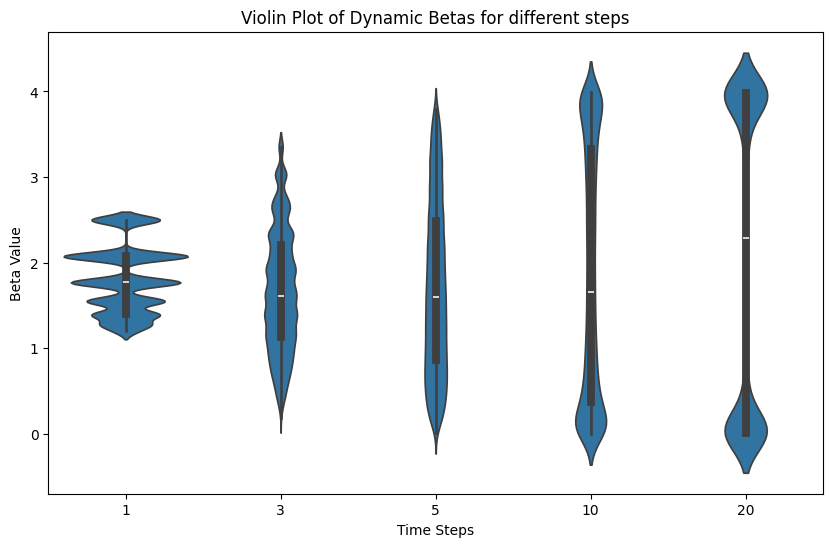

In [30]:
def extract_values(betas):
    return [v[1] for k, v in betas.items()]

# Filtering steps and preparing data for violin plot
steps_to_plot = [1, 3, 5, 10, 20]
filtered_data = df[df['Step'].isin(steps_to_plot)]
betas_values = [extract_values(betas) for betas in filtered_data['dynamic_betas']]
flat_betas = [(step, value) for step, values in zip(filtered_data['Step'], betas_values) for value in values]
violin_df = pd.DataFrame(flat_betas, columns=['Step', 'beta_value'])

# Plotting the violin diagram
plt.figure(figsize=(10, 6))
sns.violinplot(x='Step', y='beta_value', data=violin_df)
plt.title('Violin Plot of Dynamic Betas for different steps')
plt.xlabel('Time Steps')
plt.ylabel('Beta Value')

# Save the plot as an .svg file
plt.savefig('mesa_sim_figures/dynamic_betas_violin_plot_2_cluster.svg', format='svg')

# Show the plot
plt.show()

In [28]:
#for visualization of various constellations of betas and timesteps

s = 10 #timestep
i = 2 #beta variation, currently 2 or .5
df = sim[(sim.betaIntSoc == i) & (sim.Step == s)].copy()
#& (sim.betaIntPers == i) & (sim.betaExt == i)

edges_in_graph = []
for index, row in df.iterrows():
    d = ast.literal_eval(row['dynamic_betas'])
    for key, value in d.items():
            edges_in_graph.append((row.AgentID, key, value[1]))

In [31]:
def get_color(value):
    sea_blue = (39, 100, 123)  # RGB for #27647B
    blood_red = (202, 53, 66)  # RGB for #CA3542
    
    r = int(sea_blue[0] + (blood_red[0] - sea_blue[0]) * (value + 1) / 2)
    g = int(sea_blue[1] + (blood_red[1] - sea_blue[1]) * (value + 1) / 2)
    b = int(sea_blue[2] + (blood_red[2] - sea_blue[2]) * (value + 1) / 2)
    
    return f"#{r:02x}{g:02x}{b:02x}"

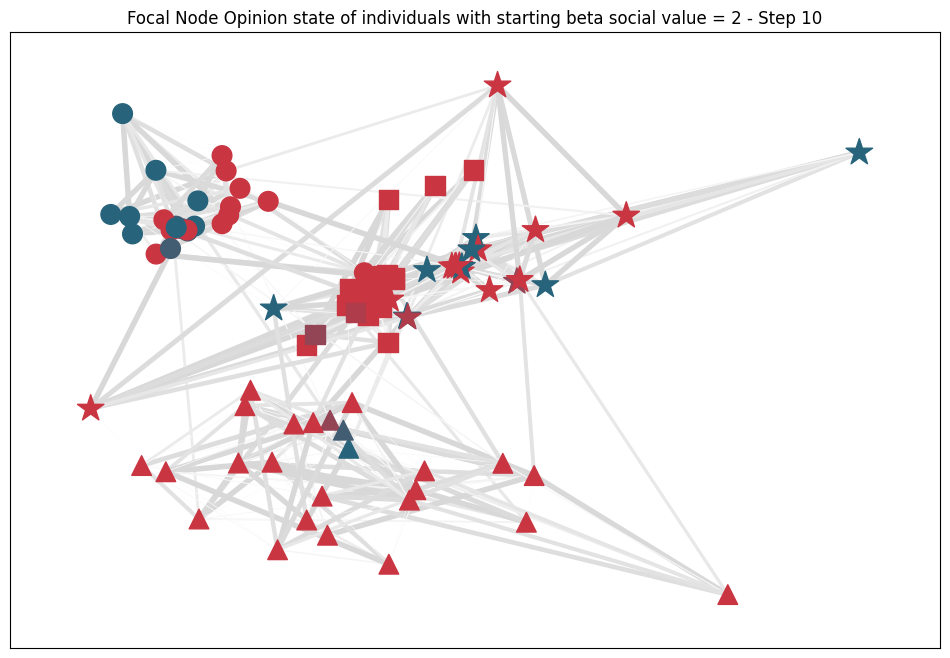

In [32]:
G = nx.Graph()

for index, row in df.iterrows():
    node_color = get_color(row['focalNodeStates'])

    if row['AgentID'] < 25:
        node_shape = 's'  # square
        node_size = 200
    elif 25 <= row['AgentID'] < 50:
        node_shape = 'o'  # circle
        node_size = 200
    elif 50 <= row['AgentID'] < 75:
        node_shape = '^'  # triangle
        node_size = 200
    else:
        node_shape = '*'  # star
        node_size = 400

    G.add_node(int(row['AgentID']), color=node_color, shape=node_shape, size=node_size)

for start, end, weight in edges_in_graph:
    intensity = 255 - int(weight * 10)
    color = f"#{intensity:02x}{intensity:02x}{intensity:02x}"
    G.add_edge(start, end, weight=weight, color=color)

pos = nx.kamada_kawai_layout(G, weight='weight')

plt.figure(figsize=(12, 8))

# Draw nodes with different shapes
node_shapes = {'s', 'o', '^', '*'}
for shape in node_shapes:
    nodes_of_shape = [node for node in G.nodes if G.nodes[node]['shape'] == shape]
    sizes_of_shape = [G.nodes[node]['size'] for node in nodes_of_shape]
    colors_of_shape = [G.nodes[node]['color'] for node in nodes_of_shape]

    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=nodes_of_shape,
        node_shape=shape,
        node_color=colors_of_shape,
        node_size=sizes_of_shape
    )

# Draw edges with custom colors and widths
edges_colors = [G.edges[edge]['color'] for edge in G.edges]
edges_widths = [G.edges[edge]['weight'] for edge in G.edges]
nx.draw_networkx_edges(G, pos, edge_color=edges_colors, width=edges_widths)

# Add a legend
legend_elements = [
    mpatches.Patch(color=get_color(-1), label='Opinion: -1'),
    mpatches.Patch(color=get_color(-0.66), label='Opinion: -0.66'),
    mpatches.Patch(color=get_color(-0.33), label='Opinion: -0.33'),
    mpatches.Patch(color=get_color(0), label='Opinion: 0'),
    mpatches.Patch(color=get_color(0.33), label='Opinion: 0.33'),
    mpatches.Patch(color=get_color(0.66), label='Opinion: 0.66'),
    mpatches.Patch(color=get_color(1), label='Opinion: 1')
]
#plt.legend(handles=legend_elements, title='Opinion State', loc='lower left')

plt.title(f'Focal Node Opinion state of individuals with starting beta social value = {i} - Step {s}')

plt.savefig(f'mesa_sim_figures/kamada_opinion_dynamic{i}_step{s}.svg', format='svg')

plt.show()


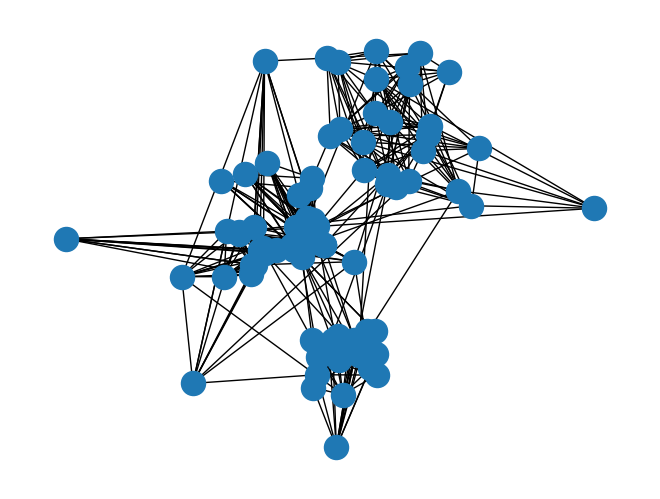

In [486]:
#Alternative

G = nx.Graph()

for index, row in df.iterrows():
    node_color = get_color(row['focalNodeStates'])

    if row['AgentID'] < 25:
        node_shape = 's'  # square
        node_size = 300
    elif 25 <= row['AgentID'] < 50:
        node_shape = 'o'  # circle
        node_size = 600
    elif 50 <= row['AgentID'] < 75:
        node_shape = '^'  # triangle
        node_size = 450
    else:
        node_shape = '*'  # star
        node_size = 450

    G.add_node(int(row['AgentID']), color=node_color, shape=node_shape, size=node_size)

for start, end, weight in edges_in_graph:
    intensity = 255 - int(weight * 50)
    color = f"#{intensity:02x}{intensity:02x}{intensity:02x}"
    G.add_edge(start, end, weight=weight, color=color)

node_colors = [G.nodes[node]['color'] for node in G.nodes]
edges_colors = [G.edges[edge]['color'] for edge in G.edges]
edges_widths = [G.edges[edge]['weight'] for edge in G.edges]

plt.figure(figsize=(12, 8))

nx.draw_kamada_kawai(
    G,
    node_color=node_colors,
    edge_color=edges_colors,
    width=edges_widths,
    with_labels=True  # Set to False if you don't want node labels
)

legend_elements = [
    mpatches.Patch(color=get_color(-1), label='Opinion: -1'),
    mpatches.Patch(color=get_color(-0.66), label='Opinion: -0.66'),
    mpatches.Patch(color=get_color(-0.33), label='Opinion: -0.33'),
    mpatches.Patch(color=get_color(0), label='Opinion: 0'),
    mpatches.Patch(color=get_color(0.33), label='Opinion: 0.33'),
    mpatches.Patch(color=get_color(0.66), label='Opinion: 0.66'),
    mpatches.Patch(color=get_color(1), label='Opinion: 1')
]
plt.legend(handles=legend_elements, title='Opinion State', loc='upper left')

plt.show()


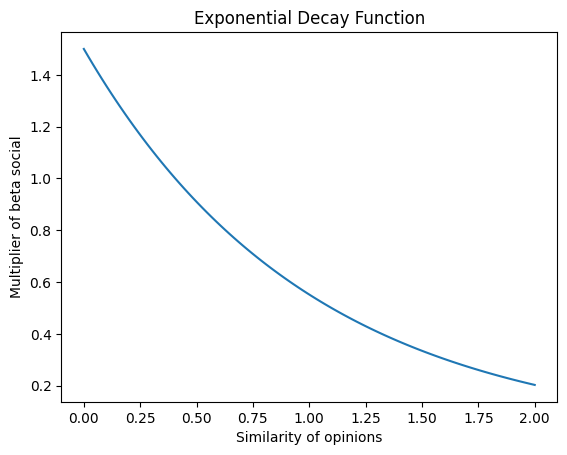

In [440]:

def exponential_decay(x, a=1.5, b=1):

    return a * np.exp(-b * x)

# Generate data
x_values = np.linspace(0, 2, 100)
y_values = exponential_decay(x_values)

# Plot the function
plt.plot(x_values, y_values)
plt.xlabel('Similarity of opinions')
plt.ylabel('Multiplier of beta social')
plt.title('Exponential Decay Function')
plt.savefig("mesa_sim_figures/exp_decay.svg", format = 'svg')

plt.show()

In [ ]:
net = Network(notebook=True, cdn_resources='in_line', height="750px", width="100%")

# Add nodes with color defined by DataFrame
for index, row in df.iterrows():
    node_color = get_color(row['focalNodeStates'])
    if row['AgentID'] < 25:
        node_shape = 'square'
        node_size = 20
    elif (row['AgentID'] >= 25) and (row['AgentID'] < 50):
        node_shape = 'ellipse'
        node_size = 40
    elif (row['AgentID'] >= 50) and (row['AgentID'] < 75):
        node_shape = 'triangle'
        node_size = 30
    elif (row['AgentID'] >= 75) and (row['AgentID'] < 100):
        node_shape = 'diamond'
        node_size = 30

    pos = nx.spring_layout(G, weight='weight'*10)

    x, y = pos[int(row['AgentID'])][0] * 1000, pos[int(row['AgentID'])][1] * 1000

    net.add_node(int(row['AgentID']), x=x, y=y, color=node_color, shape=node_shape, size=node_size)

# Add edges from NetworkX graph
for start, end, weight in edges_in_graph:
    intensity = 255 - int(weight * 20)  # Calculate intensity, more weight => darker
    color = f"#{intensity:02x}{intensity:02x}{intensity:02x}"  # Convert to hex
    net.add_edge(start, end, value=weight*0.001, color=color)

# Show the network
net.show("example.html")


In [ ]:
import matplotlib.patches as mpatches


G = nx.Graph()


for index, row in df.iterrows():
    node_color = get_color(row['focalNodeStates'])
    
    if row['AgentID'] < 50:
        node_shape = 's' 
        node_size = 300  
    elif 25 <= row['AgentID'] < 50:
        node_shape = 'o'  # ellipse (default)
        node_size = 600
    elif 50 <= row['AgentID'] < 75:
        node_shape = '^'  # triangle
        node_size = 450
    else:
        node_shape = '*' 
        node_size = 450



    G.add_node(int(row['AgentID']), color=node_color, shape=node_shape, size=node_size)


#G.add_edges_from((u, v, {"weight": 2}) for u, v in extNet.edges())

for start, end, weight in edges_in_graph:
    intensity = 255 - int(weight* 50)  
    color = f"#{intensity:02x}{intensity:02x}{intensity:02x}"  
    G.add_edge(start, end, weight=weight, color=color)

#pos = nx.spring_layout(G, weight='weight')

pos = nx.fruchterman_reingold_layout(G, weight = 'weight')

    
"""
H = nx.Graph()

H.add_nodes_from(G.nodes(data=True))


for start, end, weight in edges_in_graph:
    intensity = 255 - int(weight *20) 
    color = f"#{intensity:02x}{intensity:02x}{intensity:02x}"
    H.add_edge(start, end, weight=weight, color=color)


"""    

plt.figure(figsize=(12, 8))


for node, attr in G.nodes(data=True):
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=[node],
        node_color=[attr['color']],
        node_shape=attr['shape'],
        node_size=attr['size']
    )


#intensity = 255 - int(i* 20)  
#color = f"#{intensity:02x}{intensity:02x}{intensity:02x}"
#edges_colors = [G.edges[edge]['color'] for edge in G.edges]
#edges_widths = [G.edges[edge]['weight'] for edge in G.edges]
#nx.draw_networkx_edges(G, pos, width=edges_widths)




# Add a legend
legend_elements = [
    mpatches.Patch(color=get_color(-1), label='Opinion: -1'),
    mpatches.Patch(color=get_color(-0.66), label='Opinion: -0.66'),
    mpatches.Patch(color=get_color(-0.33), label='Opinion: -0.33'),
    mpatches.Patch(color=get_color(0), label='Opinion: 0'),
    mpatches.Patch(color=get_color(0.33), label='Opinion: 0.33'),
    mpatches.Patch(color=get_color(0.66), label='Opinion: 0.66'),
    mpatches.Patch(color=get_color(1), label='Opinion: 1')
]
plt.legend(handles=legend_elements, title='Opinion State', loc='upper left')


plt.title(f"Focal Node 'Opinion' states of individuals with static beta_soc = {i} - Step {s}")
plt.savefig(f'mesa_sim_figures/opinion_dynamic_{i}_step{s}.svg', format='svg')

plt.show()